## Handling Text Data

In this notebook we are going to:

1. Implement the natural language processing pipeline
2. Solve four typical language processing tasks:
   * Sentiment analysis
   * Document classification
   * Topic detection
   * Semantic analysis


### We will be working with four books in plain text:
1. Moby-Dick, by Herman Melville
2. Frankenstein; or, The Modern Prometheus, by Mary Shelley
3. Pride and Prejudice, by Jane Austen
4. Dracula, Bram Stoker

**Your Task** - Some essential lines of code are missing. You'll identify them when there's a code comment, followed by --> . Your task is to write those lines of code.

You may find [this resource](https://realpython.com/natural-language-processing-spacy-python/) helpful

# Intro: NLP Pipeline

We need to install the following packages

In [1]:
%pip install nltk gensim spacy 
%pip install pyLDAvis  
%pip install vaderSentiment  
%pip install empath 

!python -m spacy download en  
!python -m nltk.downloader punkt 
!python -m nltk.downloader all-corpora 

Defaulting to user installation because normal site-packages is not writeable


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 25.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 19.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.0/493.0 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.3/922.3 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

`gensim` package does not work with the new versions of `scipy`. We need to use `scipy` 1.12 or older.

In [2]:
%pip install scipy==1.12

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 614.4 kB/s eta 0:00:0000:0100:02
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.3.0 requires scipy<=1.11.4,>=1.6.1, but you have scipy 1.12.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
#import pyLDAvis.gensim
import pyLDAvis.gensim_models

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

#The data
corpus_root = 'books/'

#### In this tutorial we will be working with text in English. The same principles apply, but the methods cannot be applied directly to the text in unknown or other languages. We will be working mainly with the Spacy library.

Initialize the Spacy analyzer in English

In [4]:
nlp = spacy.load('en_core_web_sm')

Load the books

In [5]:
books = list()

for book_file in os.listdir(corpus_root):
    if ".txt" in book_file:
        print(book_file)
        with codecs.open(os.path.join(corpus_root,book_file),encoding="utf8") as f:
            books.append(f.read())

PRIDE_AND_PREJUDICE.txt
Frankenstein.txt
Moby_Dick.txt
DRACULA.txt


Print the beginning of Pride and Prejudice

In [6]:
print(books[2][0:600])

MOBY DICK;

or, THE WHALE.

By Herman Melville

ETYMOLOGY. (Supplied by a Late Consumptive Usher to a Grammar School.)

The pale Usher—threadbare in coat, heart, body, and brain; I see him
now. He was ever dusting his old lexicons and grammars, with a queer
handkerchief, mockingly embellished with all the gay flags of all
the known nations of the world. He loved to dust his old grammars; it
somehow mildly reminded him of his mortality.

“While you take in hand to school others, and to teach them by what
name a whale-fish is to be called in our tongue, leaving out, through
ignorance, the letter


#### Let's remove the new lines

In [7]:
books = [" ".join(b.split()) for b in books]

In [8]:
print(books[2][0:600])

MOBY DICK; or, THE WHALE. By Herman Melville ETYMOLOGY. (Supplied by a Late Consumptive Usher to a Grammar School.) The pale Usher—threadbare in coat, heart, body, and brain; I see him now. He was ever dusting his old lexicons and grammars, with a queer handkerchief, mockingly embellished with all the gay flags of all the known nations of the world. He loved to dust his old grammars; it somehow mildly reminded him of his mortality. “While you take in hand to school others, and to teach them by what name a whale-fish is to be called in our tongue, leaving out, through ignorance, the letter H, w


### Load Frankenstein

In [9]:
#index all books
book = books[0]

#put in raw text, get a Spacy object
doc = nlp(book)

## Let's create our own NLP pipeline with Spacy!

### Step 1: Sentence splitting

#### May sound trivial, but it's not! (e.g., U.K. or Yahoo!) Spacy uses a statistical model to generate accurate predictions. This works well out of the box for general-purpose text or web text. For social media use dedicated libraries.

In [ ]:
sentences = [sent for sent in doc.sents]
print('Sentence 1:',sentences[0],'\n')
print('Sentence 2:',sentences[1],'\n')
print('Sentence 3:',sentences[2],'\n')

Sentence 1: Frankenstein, or the Modern Prometheus by Mary Wollstonecraft (Godwin) Shelley Letter 1 St. Petersburgh, Dec. 11th, 17-- TO Mrs. Saville, England You will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings. 

Sentence 2: I arrived here yesterday, and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking. 

Sentence 3: I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 



### Step 2: Tokenization

#### The task of splitting a text into meaningful segments called tokens. We segment the sentence into words, punctuation, etc. This is done by first splitting on whitespace characters and them applying rules specific to each language. For example, "don't" does not contain whitespace, but should be split into two tokens, "do" and "n't", while "U.K." should always remain one token and "but," shouldn't.

### We will analyze the methods on an example sentence first

In [ ]:
example = 'I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight.'

doc = nlp(example)

#strings are encoded to hashes
tokens = [token.text for token in doc]

print(example,'\n')
print(tokens)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

['I', 'am', 'already', 'far', 'north', 'of', 'London', ',', 'and', 'as', 'I', 'walk', 'in', 'the', 'streets', 'of', 'Petersburgh', ',', 'I', 'feel', 'a', 'cold', 'northern', 'breeze', 'play', 'upon', 'my', 'cheeks', ',', 'which', 'braces', 'my', 'nerves', 'and', 'fills', 'me', 'with', 'delight', '.']


### Step 3: Part of speech tagging

#### The model makes a prediction of which tag or label most likely applies in this context. For example, a word following "the" in English is most likely a noun.

In [ ]:
pos_tagged = [(token.text, token.pos_) for token in doc]

print(example,'\n')
print(pos_tagged)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

[('I', 'PRON'), ('am', 'AUX'), ('already', 'ADV'), ('far', 'ADV'), ('north', 'ADV'), ('of', 'ADP'), ('London', 'PROPN'), (',', 'PUNCT'), ('and', 'CCONJ'), ('as', 'SCONJ'), ('I', 'PRON'), ('walk', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('streets', 'NOUN'), ('of', 'ADP'), ('Petersburgh', 'PROPN'), (',', 'PUNCT'), ('I', 'PRON'), ('feel', 'VERB'), ('a', 'DET'), ('cold', 'ADJ'), ('northern', 'ADJ'), ('breeze', 'NOUN'), ('play', 'VERB'), ('upon', 'SCONJ'), ('my', 'PRON'), ('cheeks', 'NOUN'), (',', 'PUNCT'), ('which', 'PRON'), ('braces', 'VERB'), ('my', 'PRON'), ('nerves', 'NOUN'), ('and', 'CCONJ'), ('fills', 'VERB'), ('me', 'PRON'), ('with', 'ADP'), ('delight', 'NOUN'), ('.', 'PUNCT')]


In [ ]:
print(spacy.explain('CCONJ'))
print(spacy.explain('ADP'))
print(spacy.explain('DET'))

coordinating conjunction
adposition
determiner


### When unsure, see here for more details: http://universaldependencies.org/u/pos/all.html

#### More detailed annotation:

In [ ]:
pos_tagged = [(token.text, token.tag_) for token in doc]

print(pos_tagged)

[('I', 'PRP'), ('am', 'VBP'), ('already', 'RB'), ('far', 'RB'), ('north', 'RB'), ('of', 'IN'), ('London', 'NNP'), (',', ','), ('and', 'CC'), ('as', 'IN'), ('I', 'PRP'), ('walk', 'VBP'), ('in', 'IN'), ('the', 'DT'), ('streets', 'NNS'), ('of', 'IN'), ('Petersburgh', 'NNP'), (',', ','), ('I', 'PRP'), ('feel', 'VBP'), ('a', 'DT'), ('cold', 'JJ'), ('northern', 'JJ'), ('breeze', 'NN'), ('play', 'VB'), ('upon', 'IN'), ('my', 'PRP$'), ('cheeks', 'NNS'), (',', ','), ('which', 'WDT'), ('braces', 'VBZ'), ('my', 'PRP$'), ('nerves', 'NNS'), ('and', 'CC'), ('fills', 'VBZ'), ('me', 'PRP'), ('with', 'IN'), ('delight', 'NN'), ('.', '.')]


In [ ]:
print(spacy.explain('PRP'))
print(spacy.explain('VBP'))

pronoun, personal
verb, non-3rd person singular present


### Step 4: Named entity recognition

#### For example, a person, a country, a product or a book title. Spacy can recognise various types of named entities in a document. This doesn't always work perfectly and might need some tuning later, depending on your use case.

Built in entity types: <br>

PERSON  People, including fictional.  <br>
NORP	Nationalities or religious or political groups. <br>
FAC	Buildings, airports, highways, bridges, etc. <br>
ORG	Companies, agencies, institutions, etc. <br>
GPE	Countries, cities, states. <br>
LOC	Non-GPE locations, mountain ranges, bodies of water. <br>
PRODUCT	Objects, vehicles, foods, etc. (Not services.) <br>
EVENT	Named hurricanes, battles, wars, sports events, etc. <br>
WORK_OF_ART	Titles of books, songs, etc. <br>
LAW	Named documents made into laws. <br>
LANGUAGE	Any named language. <br>
DATE	Absolute or relative dates or periods. <br>
TIME	Times smaller than a day. <br>
PERCENT	Percentage, including "%". <br>
MONEY	Monetary values, including unit. <br>
QUANTITY	Measurements, as of weight or distance. <br>
ORDINAL	"first", "second", etc. <br>
CARDINAL	Numerals that do not fall under another type. <br>

In [ ]:
print(example,'\n')
for ent in doc.ents:
    print(ent.text, ent.label_)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

London GPE
Petersburgh GPE


### Step 5: Removing stop words

Let's check out all the stopwords:

In [ ]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))
print('First ten stop words:',list(spacy_stopwords)[:10])

Number of stop words: 326
First ten stop words: ['former', 'side', 'nine', 'third', 'anyone', 'hereafter', 'quite', 'amount', 'those', 'into']


Detecting stopwords in the example:

In [ ]:
print(example,'\n')

stop_words = [token.text for token in doc if token.is_stop]

print(stop_words)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

['I', 'am', 'already', 'of', 'and', 'as', 'I', 'in', 'the', 'of', 'I', 'a', 'upon', 'my', 'which', 'my', 'and', 'me', 'with']


#### Sometimes it's useful to define a custom list of stopwords. Other solutions: https://www.ranks.nl/stopwords 


### Step 6: Lemmatization

#### A rule-based deterministic lemmatizer maps the surface form of a token to a lemma.

In [ ]:
print(example,'\n')
for token in doc:
    if token.text != token.lemma_:
        print(token.text,'--->',token.lemma_)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

am ---> be
streets ---> street
cheeks ---> cheek
braces ---> brace
nerves ---> nerve
fills ---> fill
me ---> I


### Counting word occurences

In [ ]:
from collections import Counter

print(example,'\n')
words = [token.text for token in doc]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common()

print(common_words)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

[('I', 3), (',', 3), ('of', 2), ('and', 2), ('my', 2), ('am', 1), ('already', 1), ('far', 1), ('north', 1), ('London', 1), ('as', 1), ('walk', 1), ('in', 1), ('the', 1), ('streets', 1), ('Petersburgh', 1), ('feel', 1), ('a', 1), ('cold', 1), ('northern', 1), ('breeze', 1), ('play', 1), ('upon', 1), ('cheeks', 1), ('which', 1), ('braces', 1), ('nerves', 1), ('fills', 1), ('me', 1), ('with', 1), ('delight', 1), ('.', 1)]


### Without stop words and punctuation

In [ ]:
#Now rewrite the above, but don't consider a token as a word if it's a stop word or punctuation mark
from spacy.lang.en import STOP_WORDS
words = [token.text for token in doc if token.text.lower() not in STOP_WORDS and token.text not in string.punctuation]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common()

print(common_words)

[('far', 1), ('north', 1), ('London', 1), ('walk', 1), ('streets', 1), ('Petersburgh', 1), ('feel', 1), ('cold', 1), ('northern', 1), ('breeze', 1), ('play', 1), ('cheeks', 1), ('braces', 1), ('nerves', 1), ('fills', 1), ('delight', 1)]


## Putting all the components together

### Under the hood: the pipeline ["tokenizer","tagger", "parser", "ner"].

#### The NLP pipeline with Spacy
<img src="spacy.png">

In [ ]:
nlp = spacy.load('en_core_web_sm')

### If you don't need a particular component of the pipeline – for example, the tagger, you can disable loading it. This can sometimes make a big difference and improve loading speed. 

In [ ]:
nlp.remove_pipe('tagger')

('tagger', <spacy.pipeline.tagger.Tagger at 0x7ff9706bf170>)

# Task 1: Sentiment analysis

### Initialize the analyzer. Typically used for data from social media (short sentences).

In [ ]:
analyzer = SentimentIntensityAnalyzer()
vs = analyzer.polarity_scores(example)

### The sentiment score consits of four values. Neutral, positive and negative sum to one. The final score is obtained by thresholding the compound value (e.g. +/-0.05).

In [ ]:
print(example, '\n')
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

Negative sentiment: 0.035
Neutral sentiment: 0.806
Positive sentiment: 0.159
Compound sentiment: 0.7096


### We can now observe the distributions of sentiment across all sentences in the book Pride and Prejudice:

In [ ]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(books[2])

Text(0, 0.5, 'Number of sentences')

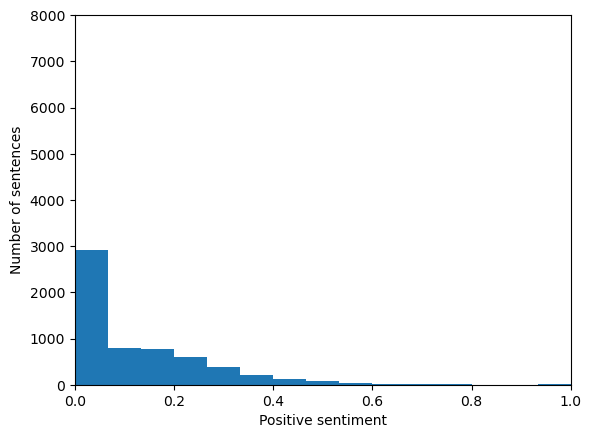

In [ ]:
positive_sent = []
#iterate through the sentences, get polarity scores, choose a value
[positive_sent.append(analyzer.polarity_scores(sent.text)['pos']) for sent in doc.sents]
plt.hist(positive_sent,bins=15)
plt.xlim([0,1])
plt.ylim([0,8000])
plt.xlabel('Positive sentiment')
plt.ylabel('Number of sentences')

Text(0, 0.5, 'Number of sentences')

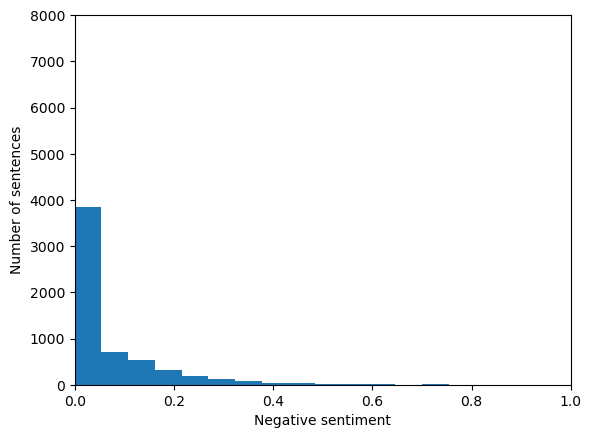

In [ ]:
negative_sent = []
#Iterate through the sentences, get negative polarity scores, choose a value
[negative_sent.append(analyzer.polarity_scores(sent.text)['neg']) for sent in doc.sents]
plt.hist(negative_sent,bins=15)
plt.xlim([0,1])
plt.ylim([0,8000])
plt.xlabel('Negative sentiment')
plt.ylabel('Number of sentences')

Text(0, 0.5, 'Number of sentences')

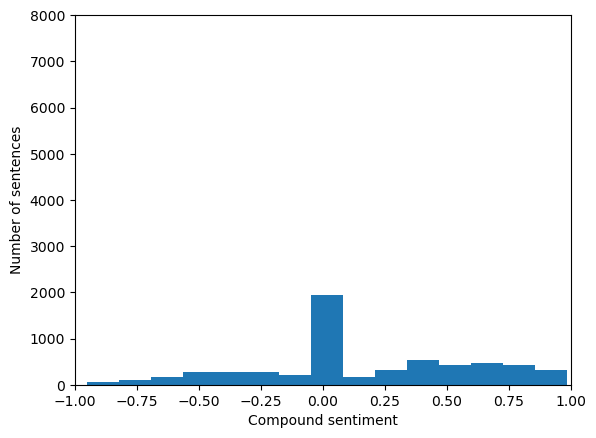

In [ ]:
total_sent = []
[total_sent.append(analyzer.polarity_scores(sent.text)['compound']) for sent in doc.sents]
plt.hist(total_sent,bins = 15)
plt.xlim([-1,1])
plt.ylim([0,8000])
plt.xlabel('Compound sentiment')
plt.ylabel('Number of sentences')

In [ ]:
sents = [analyzer.polarity_scores(sent.text)['compound'] for sent in doc.sents]
print('Number of positive sentences:',sum(np.array(sents)>=0.05))
print('Number of negative sentences:',sum(np.array(sents)<=-0.05))
print('Number of neutral sentences:',sum(np.abs(np.array(sents))<0.05))

Number of positive sentences: 2734
Number of negative sentences: 1343
Number of neutral sentences: 1872


#### Most of the sentences are quite neutral in sentiment. This is not the case when working with data from other sources (e.g., in social media opinions are strong and polarized (bimodal distribution)).

# Task 2: Document classification: Can we detect paragraphs from Frankenstein?

In [ ]:
# Let's load our corpus via NLTK this time
from nltk.corpus import PlaintextCorpusReader
PlaintextCorpusReader
our_books = PlaintextCorpusReader(corpus_root, '.*.txt')
print(our_books.fileids())

['DRACULA.txt', 'Frankenstein.txt', 'Moby_Dick.txt', 'PRIDE_AND_PREJUDICE.txt']


Init signature:
PlaintextCorpusReader(
    root,
    fileids,
    word_tokenizer=WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL),
    sent_tokenizer=<nltk.tokenize.punkt.PunktSentenceTokenizer object at 0x7ff98b283010>,
    para_block_reader=<function read_blankline_block at 0x7ff98b26fc40>,
    encoding='utf8',
)
Docstring:     
Reader for corpora that consist of plaintext documents.  Paragraphs
are assumed to be split using blank lines.  Sentences and words can
be tokenized using the default tokenizers, or by custom tokenizers
specified as parameters to the constructor.

This corpus reader can be customized (e.g., to skip preface
sections of specific document formats) by creating a subclass and
overriding the ``CorpusView`` class variable.
Init docstring:
Construct a new plaintext corpus reader for a set of documents
located at the given root directory.  Example usage:

    >>> root = '/usr/local/share/nltk_data/c

### We will segment the books into equally long chunks

In [ ]:
def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


# Get the data
book_id = {f:n for n,f in enumerate(our_books.fileids())} # dictionary of books

chunks = list()
chunk_class = list() # this list contains the original book of the chunk, for evaluation

limit = 500 # how many chunks total
size = 50 # how many sentences per chunk/page

for f in our_books.fileids():
    sentences = our_books.sents(f)
    print(f,":")
    print('Number of sentences:',len(sentences))
    
    # create chunks
    chunks_of_sents = [x for x in get_chunks(sentences,size)] # this is a list of lists of sentences, which are a list of tokens
    chs = list()
    
    # regroup so to have a list of chunks which are strings
    for c in chunks_of_sents:
        grouped_chunk = list()
        for s in c:
            grouped_chunk.extend(s)
        chs.append(" ".join(grouped_chunk))
    print("Number of chunks:",len(chs),'\n')
    
    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([book_id[f] for _ in range(len(chs[:limit]))])

DRACULA.txt :
Number of sentences: 9303
Number of chunks: 187 

Frankenstein.txt :
Number of sentences: 3378
Number of chunks: 68 

Moby_Dick.txt :
Number of sentences: 9609
Number of chunks: 193 

PRIDE_AND_PREJUDICE.txt :
Number of sentences: 6055
Number of chunks: 122 



### Representing the chunks with bag-of-words

In [ ]:
vectorizer = CountVectorizer()

#initialize and specify minumum number of occurences to avoid untractable number of features
#vectorizer = CountVectorizer(min_df = 2) if we want high frequency

#create bag of words features
X = vectorizer.fit_transform(chunks)

print('Number of samples:',X.toarray().shape[0])
print('Number of features:',X.toarray().shape[1])

#mask and convert to int Frankenstein
Y = np.array(chunk_class) == 1
Y = Y.astype(int)  

#shuffle the data
X, Y = shuffle(X, Y, random_state=0)

#split into training and test set (80-20% split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print('Number of training samples:', X_train.shape[0])
print('Number of test samples:', X_test.shape[0])

Number of samples: 570
Number of features: 23116
Number of training samples: 456
Number of test samples: 114


### Let's fit the regularized logistic regression. We will crossvalidate the regularization parameter on the training set.

In [ ]:
accs = []

#the grid of regularization parameter 
grid = [0.01,0.1,1,10,100,1000,10000]

for c in grid:
    
    #initialize the classifier
    classifier = LogisticRegression(C=c, max_iter=1000)  # You can adjust max_iter as needed


    #crossvalidate
    scores = cross_val_score(classifier, X_train, Y_train, cv=5)
    accs.append(scores.mean())


(0.986, 1.0)

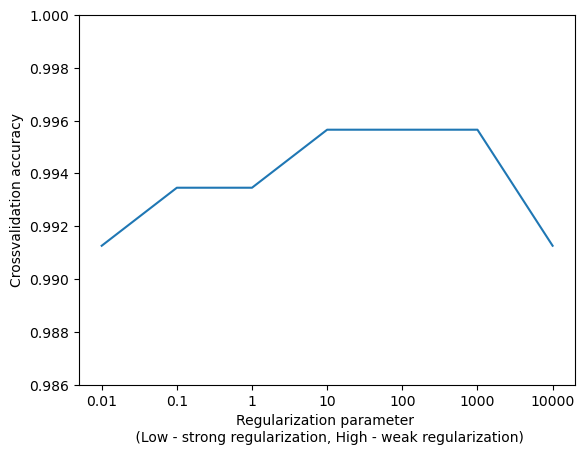

In [ ]:
plt.plot(accs)
plt.xticks(range(len(grid)), grid)
plt.xlabel('Regularization parameter \n (Low - strong regularization, High - weak regularization)')
plt.ylabel('Crossvalidation accuracy')
plt.ylim([0.986,1])

### Let's train again, on the entire training set, with the chosen regularization parameter. We will test on the test set

In [ ]:
#predict on the test set
best_c = grid[np.argmax(accs)]
clf = LogisticRegression(C=best_c, max_iter=1000)
clf.fit(X_train, Y_train)

# Predict on the test set
Y_pred = clf.predict(X_test)

# Evaluate the accuracy on the test set
accuracy = (Y_pred == Y_test).mean()
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9825


### What features characterize Frankenstein? BOW are interpretable!

In [ ]:
coefs=clf.coef_[0]
top_three = np.argpartition(coefs, -20)[-20:]

print(np.array(vectorizer.get_feature_names_out())[top_three])

['frankenstein' 'towards' 'death' 'creature' 'poor' 'misery' 'and' 'had'
 'of' 'this' 'father' 'but' 'by' 'who' 'me' 'yet' 'my' 'justine' 'which'
 'will']


### We can perfectly predict paragraphs from Frankenstein! We saw issues of high dimensionality when using bag of words (more features than samples) and how regularization helps.

### Alternative text representation: word emdeddings, pretrained on intergraded in Spacy (300-dimensional word vectors trained on Common Crawl with GloVe.) Depending on the application, might be suitable or not

In [ ]:
print(example,'\n')
print('Embedding representation:',list((nlp(example).vector)[0:10]),'...')

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

Embedding representation: [0.2009202, -0.07697441, -0.23990451, -0.0429651, 0.06303595, 0.09375225, 0.36673713, -0.08795014, 0.37766427, -0.11488461] ...


# Task 3: Topic detection

In [ ]:
# Get the chunks again (into smaller chunks)
book_id = {f:n for n,f in enumerate(our_books.fileids())} # dictionary of books
chunks = list()
chunk_class = list() # this list contains the original book of the chunk, for evaluation

limit = 60 # how many chunks total
size = 50 # how many sentences per chunk/page

for f in our_books.fileids():
    sentences = our_books.sents(f)
    print(f)
    print('Number of sentences:',len(sentences))
    
    # create chunks
    chunks_of_sents = [x for x in get_chunks(sentences,size)] # this is a list of lists of sentences, which are a list of tokens
    chs = list()
    
    # regroup so to have a list of chunks which are strings
    for c in chunks_of_sents:
        grouped_chunk = list()
        for s in c:
            grouped_chunk.extend(s)
        chs.append(" ".join(grouped_chunk))
    print("Number of chunks:",len(chs),'\n')
    
    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([book_id[f] for _ in range(len(chs[:limit]))])

DRACULA.txt
Number of sentences: 9303
Number of chunks: 187 

Frankenstein.txt
Number of sentences: 3378
Number of chunks: 68 

Moby_Dick.txt
Number of sentences: 9609
Number of chunks: 193 

PRIDE_AND_PREJUDICE.txt
Number of sentences: 6055
Number of chunks: 122 



In [ ]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

processed_docs = list()
for doc in nlp.pipe(chunks, n_process=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
docs = processed_docs
del processed_docs

In [ ]:
# Add bigrams too
from gensim.models.phrases import Phrases

# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(docs, min_count=15)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5

dictionary = Dictionary(docs)

# Filter out frequent and rare tokens
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 3087
Number of chunks: 240


In [ ]:
# models
from gensim.models import LdaMulticore
params = {'passes': 10, 'random_state': seed}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

In [ ]:
model.show_topics(num_words=5)

[(0,
  '0.008*"father" + 0.006*"life" + 0.005*"Elizabeth" + 0.005*"feeling" + 0.004*"love"'),
 (1,
  '0.007*"room" + 0.006*"door" + 0.006*"sleep" + 0.006*"Lucy" + 0.005*"old"'),
 (2,
  '0.017*"whale" + 0.011*"ship" + 0.010*"sea" + 0.008*"Queequeg" + 0.008*"old"'),
 (3,
  '0.016*"Elizabeth" + 0.012*"Darcy" + 0.011*"Bingley" + 0.010*"Miss" + 0.009*"Mrs"')]

In [ ]:
model.show_topic(1,20)

[('room', 0.0069176746),
 ('door', 0.006479864),
 ('sleep', 0.0059972685),
 ('Lucy', 0.005515721),
 ('old', 0.004992801),
 ('Count', 0.0048010205),
 ('window', 0.0044715907),
 ('dear', 0.004363028),
 ('fear', 0.0042384337),
 ('open', 0.003989994),
 ('ask', 0.0039044889),
 ('light', 0.003692846),
 ('try', 0.0035804338),
 ('sit', 0.003535181),
 ('run', 0.003509866),
 ('write', 0.0034748327),
 ('fall', 0.0034288773),
 ('lie', 0.003402803),
 ('bed', 0.0032984572),
 ('pass', 0.00325815)]

In [ ]:
sorted(model[corpus[0]],key=lambda x:x[1],reverse=True)

[(1, 0.9972272)]

In [ ]:
# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

/home/rahul/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/rahul/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/rahul/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/rahul/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/rahul/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or

In [ ]:
# assignment
sent_to_cluster = list()
for n,doc in enumerate(corpus):
    if doc:
        cluster = max(model[doc],key=lambda x:x[1])
        sent_to_cluster.append(cluster[0])

In [ ]:
# accuracy
from collections import Counter
for book, cluster in book_id.items():
    assignments = list()
    for real,given in zip(chunk_class,sent_to_cluster):
        if real == cluster:
            assignments.append(given)
    most_common,num_most_common = Counter(assignments).most_common(1)[0] # 4, 6 times
    print(book,":",most_common,"-",num_most_common)
    print("Accuracy:",num_most_common/limit)
    print("------")

DRACULA.txt : 1 - 60
Accuracy: 1.0
------
Frankenstein.txt : 0 - 54
Accuracy: 0.9
------
Moby_Dick.txt : 2 - 58
Accuracy: 0.9666666666666667
------
PRIDE_AND_PREJUDICE.txt : 3 - 60
Accuracy: 1.0
------


# Task 4: Semantic analysis based on lexical categories

In [ ]:
from empath import Empath
lexicon = Empath()

### Let's see what pre-build categories we can study! More information: https://hci.stanford.edu/publications/2016/ethan/empath-chi-2016.pdf

In [ ]:
for cat in list(lexicon.cats.keys())[:15]:
    print(cat)

help
office
dance
money
wedding
domestic_work
sleep
medical_emergency
cold
hate
cheerfulness
aggression
occupation
envy
anticipation


### For each category, we can examine representative terms

In [ ]:
lexicon.cats["health"][:15]

['kidney',
 'surgery',
 'vaccine',
 'chemotherapy',
 'flu',
 'neurologist',
 'diarrhea',
 'dehydration',
 'disease',
 'condition',
 'rehab',
 'psychologist',
 'injures',
 'psychiatric',
 'glucose']

### Studying Pride and Prejudice

In [ ]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(books[2])

In [ ]:
empath_features = lexicon.analyze(doc.text,categories = ["disappointment", "pain", "joy", "beauty", "affection"])

In [ ]:
empath_features

{'disappointment': 149.0,
 'pain': 228.0,
 'joy': 278.0,
 'beauty': 136.0,
 'affection': 439.0}

In [ ]:
empath_features = lexicon.analyze(doc.text,categories = ["disappointment", "pain", "joy", "beauty", "affection"], normalize = True)

In [ ]:
empath_features

{'disappointment': 0.0012256615693403638,
 'pain': 0.001875508978587939,
 'joy': 0.002286804807225645,
 'beauty': 0.0011187246538945602,
 'affection': 0.0036111773754390585}

### Usecase: the evolution of topics

In [ ]:
bins = range(0,len(doc.text),150000)
    

In [ ]:
love = []
pain = []
beauty = []
affection = []


for cnt,i in enumerate(bins[:-1]):
    empath_features = lexicon.analyze(doc.text[bins[cnt]:bins[cnt+1]],
                                      categories = ["love", "pain", "joy", "beauty", "affection"], normalize = True)
    love.append(empath_features["love"])
    pain.append(empath_features["pain"])
    beauty.append(empath_features["beauty"])
    affection.append(empath_features["affection"])

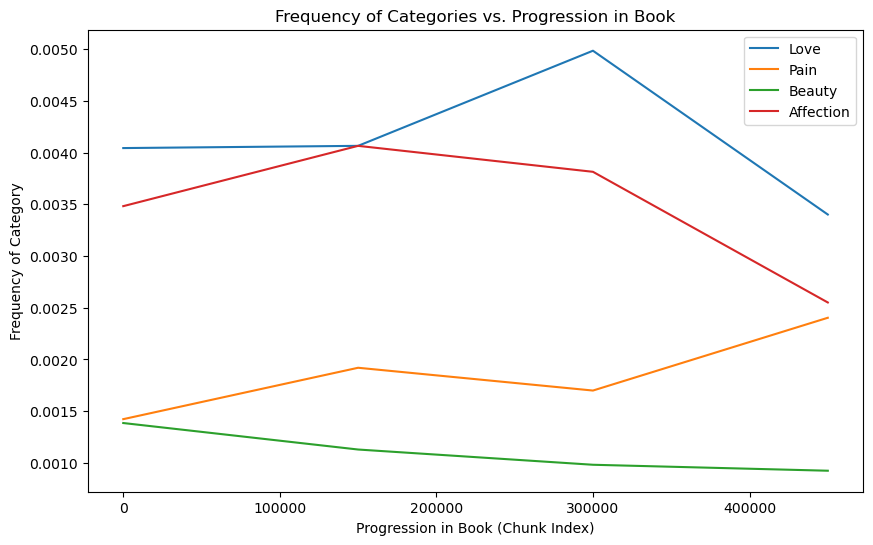

In [ ]:
#Plot frequency of a category vs progression in a book
import matplotlib.pyplot as plt



# Plot frequency of a category vs progression in a book
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], love, label='Love')
plt.plot(bins[:-1], pain, label='Pain')
plt.plot(bins[:-1], beauty, label='Beauty')
plt.plot(bins[:-1], affection, label='Affection')

# Add labels and title
plt.xlabel('Progression in Book (Chunk Index)')
plt.ylabel('Frequency of Category')
plt.title('Frequency of Categories vs. Progression in Book')
plt.legend()

# Show plot
plt.show()


In [ ]:
# What do we observe in the above plot?
print('we oberserve that the frequency of the categories love, pain, beauty, and affection change over the progression of the book. The frequency of love and beauty increases, while the frequency of pain and affection decreases.')

we oberserve that the frequency of the categories love, pain, beauty, and affection change over the progression of the book. The frequency of love and beauty increases, while the frequency of pain and affection decreases.


### We can create custom categories based on seed terms!
### Models trained on: fiction, nytimes or reddit

In [ ]:
lexicon.create_category("healthy_food", ["healthy_food","low_carb","kale","avocado"], model="nytimes")

["avocado", "kale", "Swiss_chard", "escarole", "black_beans", "cucumber", "dill", "leek", "mango", "red_peppers", "chicory", "chanterelles", "chutney", "tamarind", "papaya", "black_olives", "endive", "pesto", "walnuts", "green_beans", "bok_choy", "portobello_mushrooms", "lemon_grass", "radicchio", "ricotta", "chicken_breast", "porcini", "blue_cheese", "snow_peas", "pickled", "Gorgonzola", "chorizo", "yams", "hazelnuts", "fresh_tomatoes", "shiitake_mushrooms", "anchovies", "wild_rice", "scallion", "red_onions", "broccoli_rape", "red_cabbage", "wasabi", "sweet_potato", "feta", "roasted_garlic", "compote", "napoleon", "aioli", "crab_meat", "cauliflower", "jicama", "parsnips", "apricots", "new_potatoes", "truffle_oil", "lemongrass", "pistachios", "saut\u00e9ed", "gnocchi", "duck_confit", "fresh_herbs", "ratatouille", "white_beans", "croutons", "fresh_mozzarella", "squab", "watercress", "roasted_red_peppers", "pine_nuts", "fritters", "butternut_squash", "fava_beans", "drizzled", "red_onion"

In [ ]:
lexicon.create_category("healthy_food", ["healthy_food","low_carb","kale","avocado"], model="reddit")

["green_vegetables", "leafy_greens", "whole_grain_bread", "brown_rice", "white_rice", "green_veggies", "veggies", "whole_wheat_bread", "sweet_potatoes", "raw_veggies", "lean_meat", "spinach", "fatty_meat", "kale", "sweet_potato", "avocado", "hummus", "chicken_breast", "veggie", "whole_grain", "vegetables", "whole_wheat_pasta", "salads", "broccoli", "greek_yogurt", "Greek_yogurt", "yogurt", "avocados", "rice_cakes", "raw_vegetables", "almonds", "lean_protein", "grilled_chicken", "quinoa", "steamed_broccoli", "whole_grain_pasta", "brocolli", "kale", "avocado", "tofu", "Veggies", "edamame", "more_veggies", "lean_meats", "quinoa", "salad", "cottage_cheese", "whole_wheat", "wheat_bread", "romaine_lettuce", "white_bread", "raw_spinach", "oatmeal", "white_potatoes", "almond_butter", "pork_rinds", "veg", "cashews", "greek_yoghurt", "baby_carrots", "fresh_veggies", "fatty_meats", "more_vegetables", "avacado", "veges", "nut_butter", "hard_boiled_eggs", "carrot_sticks", "whole_grains", "grilled_c

In [ ]:
lexicon.create_category("festive_food", ["festive_food","turkey","eggnog"], model="nytimes")

["turkey", "roast_beef", "white_bread", "fried_chicken", "pancakes", "peanut_butter", "gefilte_fish", "stuffing", "French_fries", "meatloaf", "brisket", "potato_salad", "pumpkin_pie", "scrambled_eggs", "french_fries", "spaghetti", "gravy", "tamales", "pot_roast", "oatmeal", "lasagna", "corned_beef", "latkes", "pickles", "sauerkraut", "burger", "grits", "biscuits", "hamburger", "salad_bar", "corn_bread", "chicken_soup", "bacon", "cream_cheese", "brownies", "tofu", "pastrami", "pork_chops", "salami", "marshmallows", "collard_greens", "macaroni", "pies", "raw_fish", "eggnog", "cheeseburgers", "truffles", "chocolate_cake", "hard-boiled_eggs", "baked_potatoes", "venison", "cottage_cheese", "pheasant", "applesauce", "quail", "fruit_salad", "meatballs", "chocolate_chip_cookies", "tacos", "roast", "jelly", "chicken_salad", "omelet", "gumbo", "steaks", "soup", "lox", "sausage", "roast_chicken", "rye", "bagel", "fruitcake", "fries", "fried_eggs", "ketchup", "chicken_wings", "barbecue_sauce", "sw

### List of further resources
    * NLTK
    * Jellyfish: string similarity library
    * TextBlob: simplified text processing
    * PyEnchant: language detection
    * WordNet: ontology of concepts (inc. in NLTK)
    * Stanford NLP (Java)
    * Tweet NLP: https://www.cs.cmu.edu/~ark/TweetNLP/